In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import cvxpy as cp

from decentr_quad_no_constraint import *
import ciropt as co

In [2]:
# random seed
np.random.seed(108)

# data generation
problem_spec = {}
problem_spec['n_node'] = 6
# problem_spec['vector_size'] = 10
problem_spec['vector_size'] = 50
problem_spec['sc_theta'] = 1
problem_spec['sc_perturb'] = True
print(problem_spec)
problem_data = data_generation(problem_spec)
network_data = graph_generation_nodes6()

# PG-EXTRA hyperparameters
problem_data['rho'] = 2.5
problem_data['itr_num'] = 1000

{'n_node': 6, 'vector_size': 50, 'sc_theta': 1, 'sc_perturb': True}
[164.60327109342887, 0.0005340256415346454]
[199.20797573019308, 0.0152687587987891]
[189.9802189288185, 0.11094402896710795]
[185.2104090689609, 0.036871669638899686]
[192.00917518243452, 0.0005006465870797178]
[197.78982995824936, 0.0029774424855174963]


In [3]:
Q = problem_data['Q']
b = problem_data['b']
n_node = problem_spec['n_node']
vector_size = problem_spec['vector_size']

for j in range(n_node):
    U, s, V = np.linalg.svd(Q[j])
    print([np.max(s), np.min(s)])

[0.2743387851557149, 8.900427358929977e-07]
[0.33201329288365505, 2.5447931331303133e-05]
[0.3166336982146978, 0.000184906714945188]
[15.434200755746739, 0.003072639136574233]
[16.00076459853621, 4.1720548923593897e-05]
[0.32964971659708214, 4.962404142515691e-06]


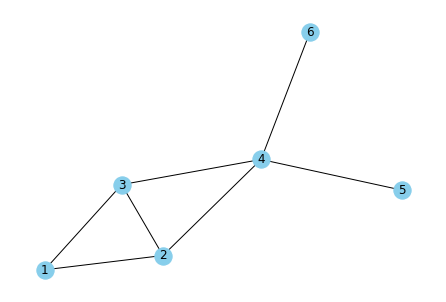

In [4]:
nx.draw(network_data["G"], node_color='skyblue', with_labels=True)
plt.savefig("plots/graph_n6.pdf")

In [5]:
f_star, x_opt_star = min_cvx_quad_no_constraint(problem_spec, problem_data)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

f_star=-4.3872948472560246e-05, np.linalg.norm(x_opt_star)=0.0045240849982876785


In [6]:
f_star, x_opt_star = min_quad_no_constraint(problem_spec, problem_data)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

f_star=-4.387294847256025e-05, np.linalg.norm(x_opt_star)=0.004524084998287679


In [7]:
Q = problem_data['Q']
b = problem_data['b']
 
vector_size = problem_spec['vector_size']
n_node = problem_spec['n_node']
prox_operators = []
fi_operators = []

# Define functions and proximal operators to implement the method
for jj in range(n_node):
    Qj = Q[jj]
    bj = b[jj]
    # prox_operators += [lambda z, rho: cvx_prox_fj_quad_no_constraint(z, rho, problem_spec, problem_data, jj) ]
    prox_operators += [lambda z, rho, Qj=Qj, bj=bj, vector_size=vector_size : prox_fj_quad_no_constraint(z, rho, Qj, bj, vector_size) ]
    fi_operators += [lambda x_kj, Qj=Qj, bj=bj : 1/2 * x_kj @ Qj @ x_kj.T + np.dot(bj[0], x_kj) ]

    c = np.random.randn(vector_size)
    x1 = prox_operators[-1](c, 1/5)
    x2 = cvx_prox_fj_quad_no_constraint(c, 1/5, problem_spec, problem_data, jj, eps=1e-4)
    assert np.linalg.norm(x1 - x2) / np.linalg.norm(x1) < 1e-5

In [8]:
params={"R":2, "Inductance":4, "Capacitance":4, "h":2.764408907848405}
# params={"R":18, "Inductance":10, "Capacitance":1, "h":1.0541046971920436}
# params={"R":18, "Inductance":10, "h":1.1054814693822324}
dadmm_c_err_opt_star, dadmm_c_err_opt_reldiff, dadmm_c_const_vio, dadmm_c_f_reldiff = co.dadmm("cir_dadmm_c", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params=params, printing=True, sc_index_set={3,4}, freq=200)

ii=0, f_reldiff[-1]=10.35625484232959
ii=200, f_reldiff[-1]=4.408244115375612e-08
ii=400, f_reldiff[-1]=2.2395536498521776e-14
ii=600, f_reldiff[-1]=1.5445197585187432e-16
ii=800, f_reldiff[-1]=1.5445197585187432e-16
ii=999, f_reldiff[-1]=0.0


In [9]:
params={"R":2, "Inductance":4, "Capacitance":4, "h":2.764408907848405}
# params={"R":18, "Inductance":10, "Capacitance":1, "h":1.0541046971920436}
# params={"R":18, "Inductance":10, "h":1.1054814693822324}
dadmm_c_all_err_opt_star, dadmm_c_all_err_opt_reldiff, dadmm_c_all_const_vio, dadmm_c_all_f_reldiff = co.dadmm("cir_dadmm_c", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params=params, printing=True, sc_index_set={1,2,3,4,5,6}, freq=200)

ii=0, f_reldiff[-1]=10.35625484232959
ii=200, f_reldiff[-1]=8.523921697817046e-07
ii=400, f_reldiff[-1]=2.4632001108856915e-12
ii=600, f_reldiff[-1]=1.5445197585187432e-16
ii=800, f_reldiff[-1]=1.5445197585187432e-16
ii=999, f_reldiff[-1]=3.0890395170374863e-16


In [28]:
# R = 18
# R = 0.1
R = 2
# R = 2
# R = 1.5
admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params={"R":R}, printing=True, freq=200)

ii=0, f_reldiff[-1]=10.35625484232959
ii=200, f_reldiff[-1]=9.64912801475229e-07
ii=400, f_reldiff[-1]=1.4793410247092523e-12
ii=600, f_reldiff[-1]=0.0
ii=800, f_reldiff[-1]=3.0890395170374863e-16
ii=999, f_reldiff[-1]=1.5445197585187432e-16


In [29]:
# apply P-EXTRA 
# problem_data['rho'] = 0.1
problem_data['rho'] = 0.2
# problem_data['rho'] = 0.5
# problem_data['rho'] = 0.1
# problem_data['rho'] = 0.01
pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = p_extra_quad_no_constraint(problem_spec, problem_data, network_data, x_opt_star, f_star, printing=True, freq=200)

ii=0, f_reldiff[-1]=5.073574720425702, err_opt_reldiff[-1]=0.6130105353717661
ii=200, f_reldiff[-1]=2.4436799610883743e-05, err_opt_reldiff[-1]=3.3808795311370125e-05
ii=400, f_reldiff[-1]=5.406243897749194e-10, err_opt_reldiff[-1]=4.7715737057010796e-09
ii=600, f_reldiff[-1]=1.3491380090661222e-12, err_opt_reldiff[-1]=1.145496248689442e-12
ii=800, f_reldiff[-1]=4.63355927555623e-16, err_opt_reldiff[-1]=6.662210167721927e-14
ii=999, f_reldiff[-1]=1.0811638309631202e-15, err_opt_reldiff[-1]=8.374804531422045e-14


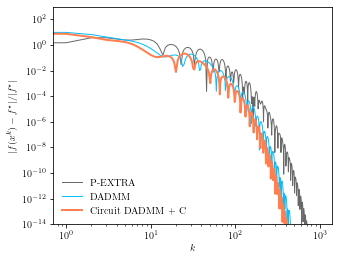

In [30]:
fname = "n6_qp_circuit_dadmm_c"

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.markersize"] = 4
plt.rcParams["legend.framealpha"] = 0.0
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["mathtext.fontset"] = 'cm' # default = 'dejavusans', other options = 'cm', 'stixsans', 'dejavuserif'
black, red, blue, green = 'dimgrey', 'coral', 'deepskyblue', 'green'

# operator norm plot (log-log plot)
plt.figure(figsize=(5,4))
plt.minorticks_off()
plt.xscale("log")
plt.yscale("log")
plt.plot(pg_f_reldiff, label='P-EXTRA', color=black, linewidth=1)
plt.plot(admm_f_reldiff, label='DADMM', color=blue, linewidth=1)
# plt.plot(dadmm_c_all_f_reldiff, label='Circuit DADMM + C-All',  color=green, linewidth=1)
plt.plot(dadmm_c_f_reldiff, label='Circuit DADMM + C',  color=red, linewidth=2)
plt.xlabel(r"$k$")
plt.ylabel(r"$|f(x^k) - f^\star|/|f^\star|$")
# plt.ylabel(r"$\|\tilde{\mathbf{A}}x_k\|^2_M$")
plt.ylim(1e-14, 1e+3)
# plt.autoscale(enable=True, axis='y', tight=None)
plt.legend()
plt.savefig(f'plots/freldif_{fname}.pdf', dpi=300)